
===== Demonstração =====
Entradas: T=20°C | UR=35% | Pessoas=1
   => Ventilação sugerida: 29.0  (% – FRACA)
Entradas: T=24°C | UR=50% | Pessoas=4
   => Ventilação sugerida: 50.0  (% – MODERADA)
Entradas: T=28°C | UR=55% | Pessoas=8
   => Ventilação sugerida: 66.6  (% – FORTE)
Entradas: T=30°C | UR=70% | Pessoas=2
   => Ventilação sugerida: 84.4  (% – FORTE)
Entradas: T=26°C | UR=40% | Pessoas=15
   => Ventilação sugerida: 83.1  (% – FORTE)


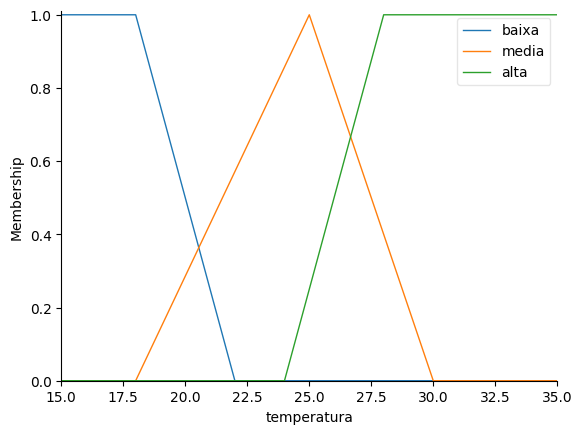

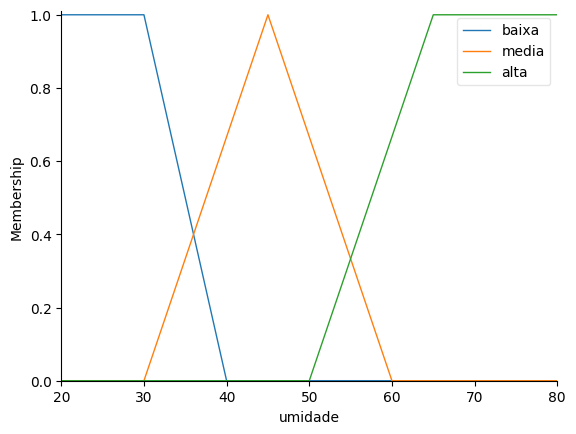

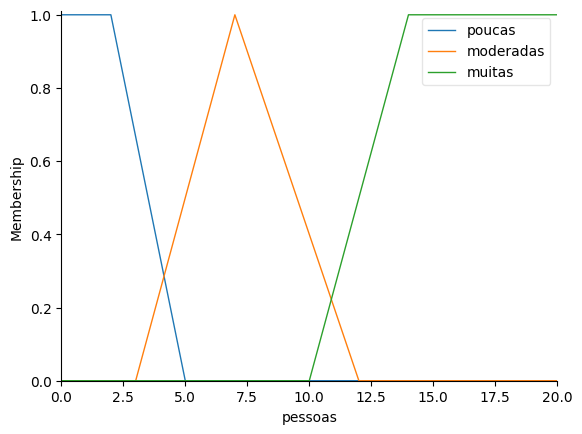

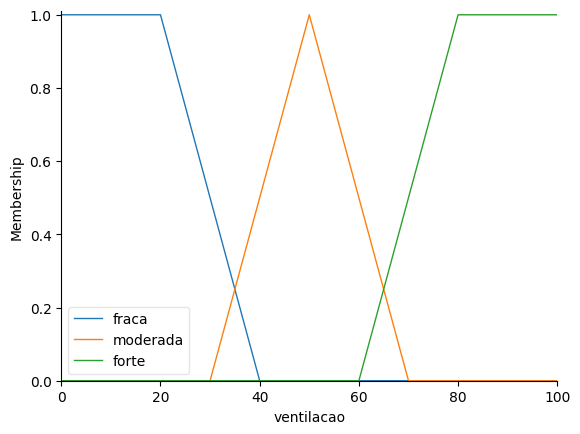

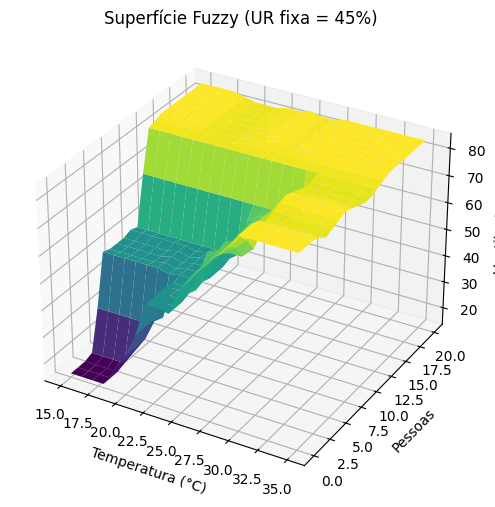

In [4]:
"""
Controle de ventilação (Mamdani Fuzzy)
Autor: Matheus Coelho e Rodrigo
Requisitos: pip install scikit-fuzzy matplotlib numpy
"""

import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt


# --------------------------------------------------
# 1. Definição dos universos e das variáveis linguísticas
# --------------------------------------------------
temp   = ctrl.Antecedent(np.arange(15, 36, 1),  'temperatura')   # °C
umid   = ctrl.Antecedent(np.arange(20, 81, 1),  'umidade')       # %
pessoas= ctrl.Antecedent(np.arange(0, 21, 1),   'pessoas')       # nº

vent   = ctrl.Consequent(np.arange(0, 101, 1),  'ventilacao')    # % de potência do ventilador


# --------------------------------------------------
# 2. Funções de pertinência
# --------------------------------------------------
# Temperatura
temp['baixa'] = fuzz.trapmf(temp.universe,  [15, 15, 18, 22])
temp['media'] = fuzz.trimf(temp.universe,   [18, 25, 30])
temp['alta']  = fuzz.trapmf(temp.universe,  [24, 28, 35, 35])

# Umidade
umid['baixa'] = fuzz.trapmf(umid.universe,  [20, 20, 30, 40])
umid['media'] = fuzz.trimf(umid.universe,   [30, 45, 60])
umid['alta']  = fuzz.trapmf(umid.universe,  [50, 65, 80, 80])

# Pessoas
pessoas['poucas']    = fuzz.trapmf(pessoas.universe, [0, 0, 2, 5])
pessoas['moderadas'] = fuzz.trimf(pessoas.universe,  [3, 7, 12])
pessoas['muitas']    = fuzz.trapmf(pessoas.universe, [10, 14, 20, 20])

# Intensidade de ventilação
vent['fraca']    = fuzz.trapmf(vent.universe, [0, 0, 20, 40])
vent['moderada'] = fuzz.trimf(vent.universe, [30, 50, 70])
vent['forte']    = fuzz.trapmf(vent.universe, [60, 80, 100, 100])


# --------------------------------------------------
# 3. Base de regras (conjunto completo de regras)
# --------------------------------------------------
rules = [
    # Temperatura baixa
    ctrl.Rule(temp['baixa'] & umid['baixa'] & pessoas['poucas'], vent['fraca']),
    ctrl.Rule(temp['baixa'] & umid['baixa'] & pessoas['moderadas'], vent['fraca']),
    ctrl.Rule(temp['baixa'] & umid['baixa'] & pessoas['muitas'], vent['moderada']),
    
    ctrl.Rule(temp['baixa'] & umid['media'] & pessoas['poucas'], vent['fraca']),
    ctrl.Rule(temp['baixa'] & umid['media'] & pessoas['moderadas'], vent['moderada']),
    ctrl.Rule(temp['baixa'] & umid['media'] & pessoas['muitas'], vent['forte']),
    
    ctrl.Rule(temp['baixa'] & umid['alta'] & pessoas['poucas'], vent['moderada']),
    ctrl.Rule(temp['baixa'] & umid['alta'] & pessoas['moderadas'], vent['moderada']),
    ctrl.Rule(temp['baixa'] & umid['alta'] & pessoas['muitas'], vent['forte']),
    
    # Temperatura média
    ctrl.Rule(temp['media'] & umid['baixa'] & pessoas['poucas'], vent['fraca']),
    ctrl.Rule(temp['media'] & umid['baixa'] & pessoas['moderadas'], vent['moderada']),
    ctrl.Rule(temp['media'] & umid['baixa'] & pessoas['muitas'], vent['forte']),
    
    ctrl.Rule(temp['media'] & umid['media'] & pessoas['poucas'], vent['moderada']),
    ctrl.Rule(temp['media'] & umid['media'] & pessoas['moderadas'], vent['moderada']),
    ctrl.Rule(temp['media'] & umid['media'] & pessoas['muitas'], vent['forte']),
    
    ctrl.Rule(temp['media'] & umid['alta'] & pessoas['poucas'], vent['forte']),
    ctrl.Rule(temp['media'] & umid['alta'] & pessoas['moderadas'], vent['forte']),
    ctrl.Rule(temp['media'] & umid['alta'] & pessoas['muitas'], vent['forte']),
    
    # Temperatura alta
    ctrl.Rule(temp['alta'] & umid['baixa'] & pessoas['poucas'], vent['moderada']),
    ctrl.Rule(temp['alta'] & umid['baixa'] & pessoas['moderadas'], vent['forte']),
    ctrl.Rule(temp['alta'] & umid['baixa'] & pessoas['muitas'], vent['forte']),
    
    ctrl.Rule(temp['alta'] & umid['media'] & pessoas['poucas'], vent['forte']),
    ctrl.Rule(temp['alta'] & umid['media'] & pessoas['moderadas'], vent['forte']),
    ctrl.Rule(temp['alta'] & umid['media'] & pessoas['muitas'], vent['forte']),
    
    ctrl.Rule(temp['alta'] & umid['alta'] & pessoas['poucas'], vent['forte']),
    ctrl.Rule(temp['alta'] & umid['alta'] & pessoas['moderadas'], vent['forte']),
    ctrl.Rule(temp['alta'] & umid['alta'] & pessoas['muitas'], vent['forte']),
]

control_system   = ctrl.ControlSystem(rules)
simulador        = ctrl.ControlSystemSimulation(control_system)


# --------------------------------------------------
# 4. Função utilitária para consultar o sistema
# --------------------------------------------------
def avaliar(temp_c, umid_rel, n_pessoas, verbose=True):
    simulador.reset()
    simulador.input['temperatura'] = temp_c
    simulador.input['umidade']     = umid_rel
    simulador.input['pessoas']     = n_pessoas
    simulador.compute()

    saida = simulador.output['ventilacao']
    if verbose:
        print(f'Entradas: T={temp_c}°C | UR={umid_rel}% | Pessoas={n_pessoas}')
        print(f'   => Ventilação sugerida: {saida:.1f}  (% – {qualitativo(saida)})')
    return saida

def qualitativo(valor):
    if valor < 35:    return 'FRACA'
    if valor < 65:    return 'MODERADA'
    return 'FORTE'


# --------------------------------------------------
# 5. Demonstração rápida com 5 cenários distintos
# --------------------------------------------------
cenarios = [
    (20, 35, 1),
    (24, 50, 4),
    (28, 55, 8),
    (30, 70, 2),
    (26, 40, 15),
]

print('\n===== Demonstração =====')
for t, u, p in cenarios:
    avaliar(t, u, p)

# --------------------------------------------------
# 6. Gráficos (opcional)
# --------------------------------------------------
def plotar_base():
    temp.view(); umid.view(); pessoas.view(); vent.view();
    plt.show()

def superficie(t_var='temperatura', u_var='pessoas'):
    # Gera uma superfície 3-D mantendo umidade média (45%)
    x = temp.universe
    y = pessoas.universe
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(len(x)):
        for j in range(len(y)):
            try:
                simulador.reset()
                simulador.input['temperatura'] = X[j, i]
                simulador.input['umidade']     = 45            # fixa
                simulador.input['pessoas']     = Y[j, i]
                simulador.compute()
                Z[j, i] = simulador.output['ventilacao']
            except:
                # Se falhar, use um valor padrão ou o último valor válido
                Z[j, i] = 50  # valor médio como fallback

    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    fig = plt.figure(figsize=(8, 6))
    ax  = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('Temperatura (°C)')
    ax.set_ylabel('Pessoas')
    ax.set_zlabel('Ventilação (%)')
    plt.title('Superfície Fuzzy (UR fixa = 45%)')
    plt.show()

plotar_base()       # Funções de pertinência
superficie()        # Superfície 3-D